In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

from scripts import *

# Feature Selection

## Multivariate regression based on MPI Index

Multidimensional Poverty Index is a product percentage of population in multidimensional poverty, $H$, and intensity of deprivation among the poor, $A$ (given as percentage of weighted deprivations):

$$MPI = HA$$

Load the data:

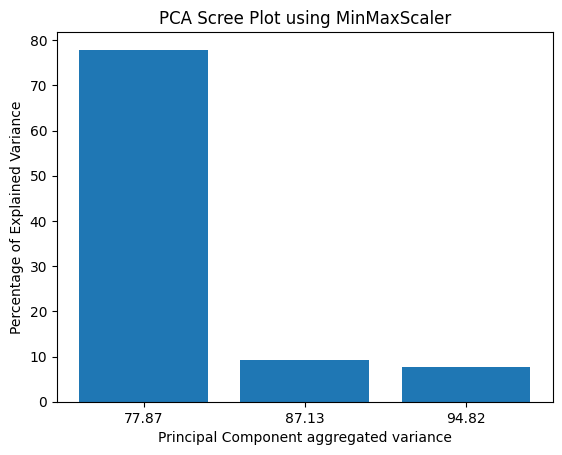

(0.5713293711147613, 167.4845081165468, 0.6123704958013918)

In [6]:
columns_to_drop = ['year',
                   'percentage_population_in_multidimensional_poverty',
                   'poverty_vulnerability',
                   'severe_poverty',
                   'percentage_population_in_multidimensional_destitution_poverty',
                   'proportion_of_mpi_ppor_who_are_destitute',
                   'deprevation_intensity']

data_raw = pd.read_csv('../data/country-data.csv')
mpi_data = pd.read_csv("../data/national_mpi.csv", delimiter=";").drop(columns=columns_to_drop, axis=1)
mpi_area = pd.read_csv("../data/MPI.csv")
mpm_data = pd.read_csv("../data/mpm_worlbank.csv", delimiter=";")

for column in mpi_data.columns:
    if column != 'country':
        mpi_data[column] = mpi_data[column].str.replace(',', '.').astype(float)

mpi_area.columns = [s.replace(' ', '_').lower() for s in mpi_area.columns]

# merge dataframes
raw_n_mpi = pd.merge(
    data_raw,
    mpi_data,
    on='country',
    how='inner'
)

raw_n_area = pd.merge(
    data_raw,
    mpi_area,
    on='country',
    how='inner',  # use 'left' to keep all rows from the left table
)

#countries = raw_n_mpi.country
#raw_n_mpi = raw_n_mpi.drop(columns=["country"]) 

features = ['country', 'mpi', 'gdpp', 'child_mort', 'total_fer', 'life_expec']
countries, clusters = pre_process_data(raw_n_mpi[features], scaler="minmax", pca_components=3, plot_scree_plot=True, pca=True)
clusters = apply_hierarchical_clustering(clusters, 2)
scatter_plot_data(clusters, ['PC1', 'PC2', 'PC3'], clusters.index, three=False)
evalutate_clusters(clusters)

(array([1., 2., 8., 5., 9., 5., 5., 7., 9., 0., 2., 2., 2., 4., 4., 2., 7.,
        4., 3., 3., 1., 2., 1., 1., 1.]),
 array([-0.69668073, -0.62816383, -0.55964693, -0.49113003, -0.42261313,
        -0.35409623, -0.28557933, -0.21706243, -0.14854553, -0.08002863,
        -0.01151173,  0.05700517,  0.12552207,  0.19403897,  0.26255587,
         0.33107277,  0.39958967,  0.46810657,  0.53662347,  0.60514037,
         0.67365727,  0.74217417,  0.81069107,  0.87920797,  0.94772487,
         1.01624177]),
 <BarContainer object of 25 artists>)

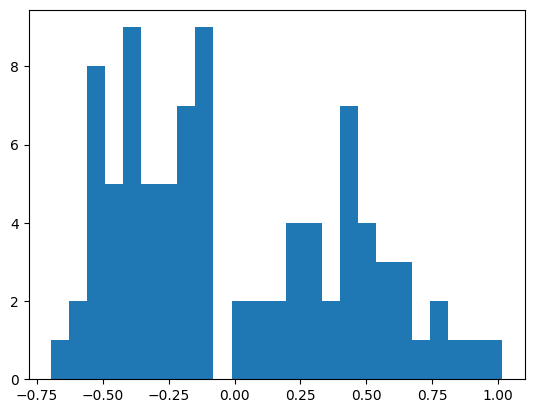

In [3]:
plt.hist(clusters.PC1, bins=25)

Scale the data:

In [4]:
scaler = MinMaxScaler()
scaled_combined = scaler.fit_transform(raw_n_mpi) # numpy array

raw_n_mpi = pd.DataFrame(scaled_combined, columns=features)
raw_n_mpi.index = countries

method = 'pearson'

plt.figure(figsize=(10,7))
sns.heatmap(raw_n_mpi.corr(method=method, min_periods=1),annot=True)
plt.title(method.title(), fontsize=18)

ValueError: could not convert string to float: 'Afghanistan'

Consider MPI as dependent variable and see how much other features are correlated with it

                            OLS Regression Results                            
Dep. Variable:                    mpi   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     186.2
Date:                Fri, 30 Dec 2022   Prob (F-statistic):           1.97e-23
Time:                        17:13:25   Log-Likelihood:                 48.148
No. Observations:                  90   AIC:                            -92.30
Df Residuals:                      88   BIC:                            -87.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0195      0.023     -0.833      0.4

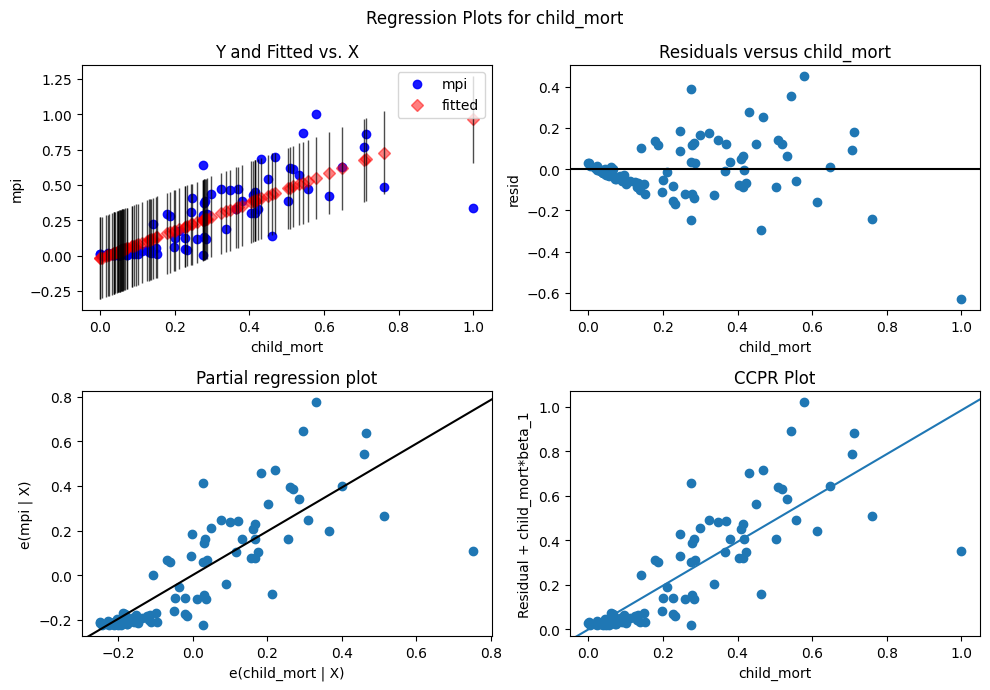

In [ ]:
reg = linear_model.LinearRegression()

# fit simple linear regression model
model = ols('mpi ~ child_mort', data=raw_n_mpi).fit()

#view model summary
print(model.summary())

#define figure size
fig = plt.figure(figsize=(10,7))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'child_mort', fig=fig)

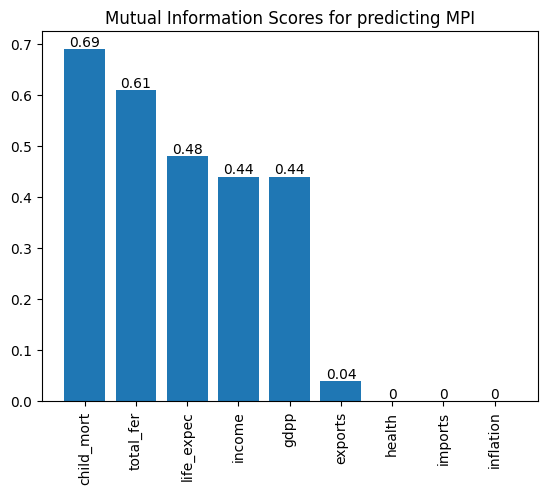

In [ ]:
def make_mi_scores(X, y, show: bool = False):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    
    if show:
        fig, ax = plt.subplots()
        bars = ax.bar(mi_scores.index, [round(x,2) for x in mi_scores.values])
        ax.bar_label(bars)
        plt.xticks(rotation=90)
        plt.title("Mutual Information Scores for predicting MPI")
        plt.show()
    return mi_scores

mi_scores = make_mi_scores(raw_n_mpi.drop("mpi", axis=1), 
                           raw_n_mpi['mpi'],
                           show=True)


Do the same for all other attributes in raw data that we have (exports, life_expectancy, etc). Then for further steps refer to:
https://www.kaggle.com/code/lauraviera/using-ml-to-allocate-funding-for-development-aid